Note: this notebook has a method of calculating distances between ECTs by using `np.roll` at the beginning, but at the end it has another method by using orientation by PCA. Documentation could be better, this is just to explore.

# Import modules

In [1]:
#-----------------
# Standard imports
#-----------------
import numpy as np # for arrays
import matplotlib.pyplot as plt # for plotting
from sklearn.decomposition import PCA # for PCA for normalization
from scipy.spatial import distance_matrix

from os import listdir # for retrieving files from directory
from os.path import isfile, join # for retrieving files from directory
from sklearn.manifold import MDS # for MDS
import pandas as pd # for loading in colors csv
from scipy.spatial import ConvexHull # for convex hull
import seaborn as sns # for plotting
import math # for isnan

#---------------------------
# The ECT packages we'll use
#---------------------------
from ect import ECT, EmbeddedGraph # for calculating ECTs

# Define functions

In [2]:
def normalize(shape):
    """
    input: ordered coordinates of a 2D closed contour
    output: 2D array, coordinates origin centered on centroid and longest radius = 1
    """
    pca = PCA(n_components=2) # initiate PCA
    pca.fit_transform(shape) # fit PCA to leaf data to find longest axis
    pca_scores = pca.transform(shape) # retrieve PCA scores of leaf

    # return leaf normalized by longest axis to 1, zero centered
    return pca_scores/(np.max(pca_scores[:,0])-np.min(pca_scores[:,0]))

In [3]:
def get_ect(normal_sh, dir_num, thresh_num, global_bound_radius):
    """
    inputs: ordered coordinates of a normalized 2D closed contour, longest diameter = 1
    dir_num = number of directional axes
    thresh_num = number of thresholds
    global_bound_radius = half of the longest normalized diameter
    output: ECT as 2D array
    """
    G = EmbeddedGraph() # initiate an embedded graph

    valuesX = normal_sh[:,0] # isolate x vals
    valuesY = normal_sh[:,1] # isolate y vals
    for i in range(np.shape(normal_sh)[0]): # create nodes
        G.add_node(i,valuesX[i],valuesY[i])
    for i in range(np.shape(normal_sh)[0]-1): # create edges
        G.add_edge(i, i+1)
    G.add_edge(0,np.shape(normal_sh)[0]-1) # add final edge between start and end

    myect = ECT(num_dirs = dir_num, num_thresh=thresh_num) # intiate ECT
    myect.set_bounding_radius(global_bound_radius) # set bounding radius
    myect.calculateECT(G) # calculate ECT on embedded graph

    return myect.get_ECT() # retrieve ECT, 2D array, [axes, thresh]

In [4]:
def ect_diff(ect1, ect2,dir_num):
    """
    inputs: two, 2D arrays of ECTs and number of directional axes
    output: the minimum sum diff between the two ECT arrays across different orientations
    """
    diffs = [] # store differences 
    for i in range(dir_num): # for the number of directional axes
        roll_ect = np.roll(ect1,i,axis=0) # roll the array by 1 along directional axes
        diff_ect = np.abs(ect2 - roll_ect) # difference between the two arrays
        diffs.append(np.sum(diff_ect)) # store the sum of the differences
    return np.min(diffs) # return minimum difference

In [5]:
def poly_area(x,y):
    """
    define a function to calculate the area of a polygon using the shoelace algorithm
    inputs: separate numpy arrays of x and y coordinate values
    outputs: the area of the polygon
    """
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

# Convert `.txt` files to `.npy`

Deleted rows `6237` to `6269` in `SampleTable.csv` because `Sample_Number` was empty/`NaN`

In [6]:
cell_df = pd.read_csv("./SampleTable.csv", encoding='unicode_escape') # read in data

In [7]:
for i in range(len(cell_df)): # for each of the cell outlines
    
    if i%1000==0: # print every 1000th i
        print(i)
    
    name = cell_df["Sample_Number"].iloc[i] # get the sample name
    
    if (name=="gp15-104-22") | (name=="JH15-010-ad-6"): # these files weren't present
        continue # skip them

    # files with "g" or "J" have x and y header in first row we need to remove
    if (name[0]=="g") | (name[0]=="J"):
        curr_file = "./CellCoordinates/"+cell_df["Sample_Number"].iloc[i]+".txt" # get current file
        curr_cell = np.loadtxt(curr_file,skiprows=1) # load current cell, skip header of x and y
        np.save("./npy_files/"+cell_df["Sample_Number"].iloc[i]+".npy",curr_cell) # save npy file

    else: # otherwise, just load in the file as is
        curr_file = "./CellCoordinates/"+cell_df["Sample_Number"].iloc[i]+".txt" # get current file
        curr_cell = np.loadtxt(curr_file) # load current cell
        np.save("./npy_files/"+cell_df["Sample_Number"].iloc[i]+".npy",curr_cell) # save npy file

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000


# Create a downsampled dataset

`Major Clade` with `eudicots`, `monocots`, `early_diverging_angiosperms`, `gymnosperms`, and `ferns` seems the most manageable factor to start with. The minimum sample number is ~200. So let's randomly sample 200 samples from each factor level.

In [8]:
cell_df["Major Clade"].value_counts() # value counts for Major Clade

Major Clade
eudicots                       6548
ferns                          2176
monocots                       1845
gymnosperms                     570
early_diverging_angiosperms     209
Name: count, dtype: int64

In [9]:
rand_num = 200 # select number to randomly sample
df_list = [] # a list to store pandas dataframes
rand_state = 42 # set the random state

for i in cell_df["Major Clade"].unique(): # for each group
    curr_group = cell_df[cell_df["Major Clade"]==i] # select all samples of current group
    df_list.append(curr_group.sample(n=rand_num, random_state=rand_state)) # select random rows for the current group
    
rand_df = pd.concat(df_list).reset_index() # concatenate list of dataframes together

print(len(rand_df)) # print the overall length of the selected cells

1000


# Analyze solidity and aspect ratio

Calculate solidity and aspect ratio

In [10]:
solidity = [] # store solidity values
wl_ratio = [] # store width-to-length ratio values

for i in range(len(rand_df)): # for each of the randomly selected leaves
    
    curr_file = "./npy_files/"+rand_df["Sample_Number"].iloc[i]+".npy" # get current file
     
    # calculate solidity
    curr_cell = np.load(curr_file) # load current cell
    hull = ConvexHull(curr_cell) # calculate convex hull of current cell
    vertices = hull.vertices # isolate vertex indices of convex hull
    area = poly_area(curr_cell[:,0], curr_cell[:,1]) # calculate area
    convex_area = poly_area(curr_cell[vertices,0], curr_cell[vertices,1]) # calculate convex area
    solidity.append( area / convex_area ) # calculate solidity and store

    # calculate length-to-width ratio
    pca = PCA(n_components=2) # initiate PCA
    pca.fit_transform(curr_cell) # fit PCA to cell data to find longest axis
    pca_scores = pca.transform(curr_cell) # retrieve PCA scores of cell
    length = np.max(pca_scores[:,0])-np.min(pca_scores[:,0]) # get length
    width = np.max(pca_scores[:,1])-np.min(pca_scores[:,1]) # get width
    wl_ratio.append(width/length) # store length-to-width ratio
    
rand_df["solidity8"] = np.array(solidity)**8 # add solidity to random cells
rand_df["wl_ratio"] = wl_ratio # add width-to-length ratio to random cells

Plot solidity and aspect ratio

Text(0.5, 1.0, 'Solidity^8 vs width-to-length ratio\nby Major Clade')

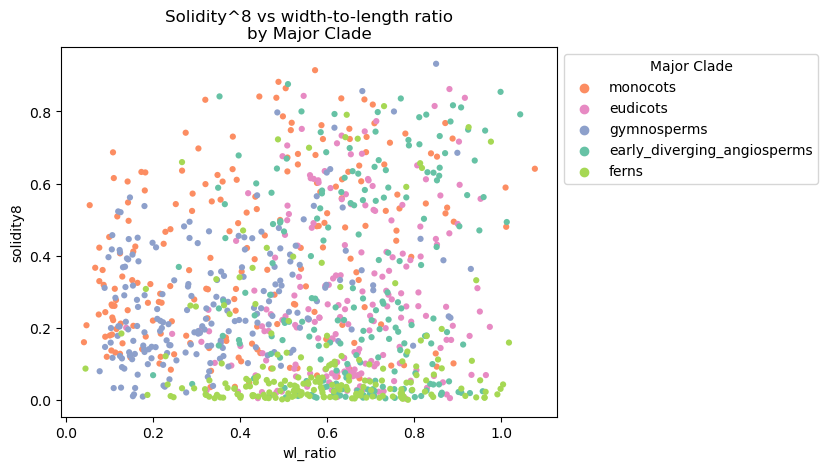

In [12]:
palette = ["#fc8d62","#e78ac3","#8da0cb","#66c2a5","#a6d854"]

ax = sns.scatterplot(data=rand_df,
                x="wl_ratio",
                y="solidity8",
                hue="Major Clade",
                palette=sns.color_palette(palette, 5),
                s=20,
                linewidth=0,
                alpha=1
               )
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title("Solidity^8 vs width-to-length ratio\nby Major Clade")

Plot solidity and aspect ratio with leaf outlines

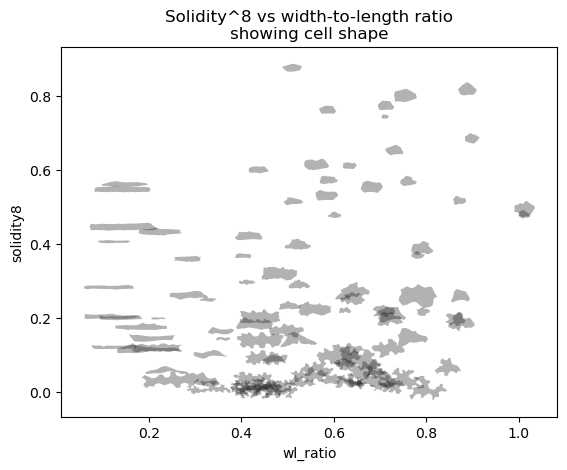

In [13]:
rand_num = 100 # set number of random cells to visualize
scale = 0.00025 # set scale of cells
rand_state = 42 # set the random state

rand_plot_df = rand_df.sample(n=rand_num, random_state=rand_state) # select random cells

for i in range(len(rand_plot_df)): # for each of the randomly selected cells
    
    curr_file = "./npy_files/"+rand_plot_df["Sample_Number"].iloc[i]+".npy" # get current file
    curr_lf = np.load(curr_file)
    pca = PCA(n_components=2) # initiate PCA
    pca.fit_transform(curr_lf) # fit PCA to cell data to find longest axis
    pca_scores = pca.transform(curr_lf) # retrieve PCA scores of cell
    
    curr_lfx = pca_scores[:,0]*scale+rand_plot_df["wl_ratio"].iloc[i]
    curr_lfy = pca_scores[:,1]*scale+rand_plot_df["solidity8"].iloc[i]
    
    plt.fill(curr_lfx, curr_lfy, lw=0, c="k", alpha=0.3)
    plt.xlabel("wl_ratio")
    plt.ylabel("solidity8")
    plt.title("Solidity^8 vs width-to-length ratio\nshowing cell shape")

# Calculate ECTs for each cell

In [14]:
num_dir=32 # set number of directional axes
num_thresh=48 # set number of thresholds each axis
rad = 0.5 # set the radius

# create array to store ECT outputs
# number of ECTs x num directional axes x number of thresholds
ect_arr = np.zeros((len(rand_df),num_dir,num_thresh))

for i in range(len(rand_df)): # for each cell
    if i%100==0: # print if divisible by 100
        print(i)
    shape = np.load("./npy_files/"+rand_df["Sample_Number"].iloc[i]+".npy") # get the current shape
    ect_arr[i,:,:] = get_ect(normal_sh=normalize(shape), # normalize the shape
           dir_num=num_dir, # calculate the ECT
           thresh_num=num_thresh,
           global_bound_radius=rad)

0
100
200
300
400
500
600
700
800
900


# Plot leaves next to ECTs

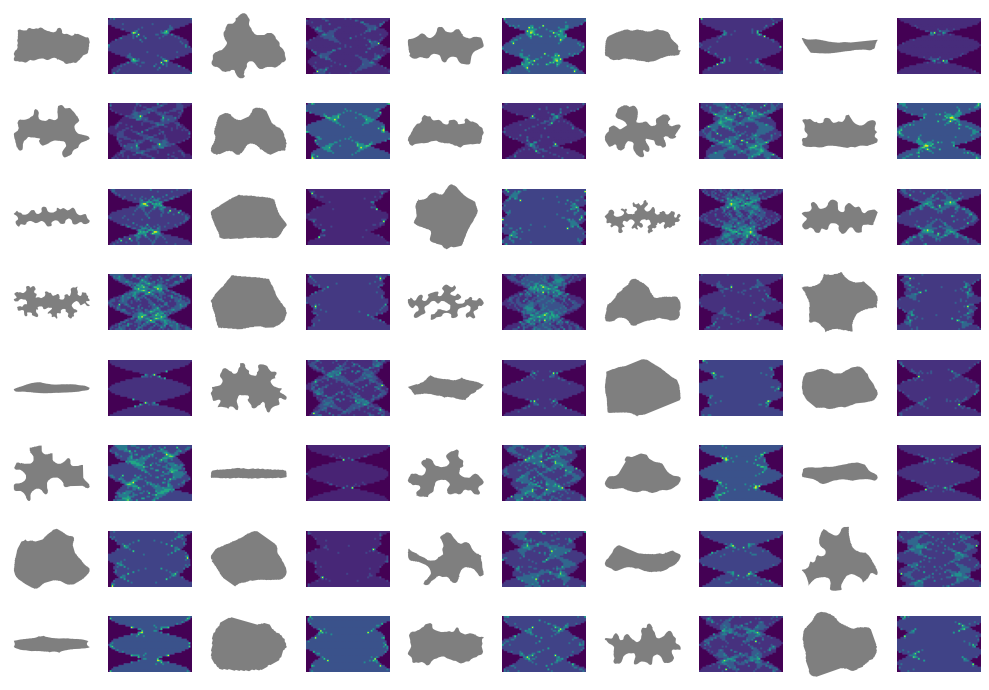

In [15]:
rand_num = 40 # set number of random cells to visualize
rand_state = 42 # set the random state

rand_ect_df = rand_df.sample(n=rand_num, random_state=rand_state) # select random cells

counter = 1 # counter for plt.subplot
plt.figure(figsize=(10,7))

for i in rand_ect_df.index: # for each of the randomly chosen indices
    
    plt.subplot(8,10,counter)
    curr_file = "./npy_files/"+rand_ect_df["Sample_Number"][i]+".npy" # get current file
    curr_cell = np.load(curr_file) # load current cell
    pca = PCA(n_components=2) # initiate PCA
    pca.fit_transform(curr_cell) # fit PCA to cell data to find longest axis
    pca_scores = pca.transform(curr_cell) # retrieve PCA scores of cell
    plt.fill(pca_scores[:,0], pca_scores[:,1], lw=0, c="k", alpha=0.5)
    plt.axis("off")
    plt.gca().set_aspect("equal")
    
    counter+=1
    
    plt.subplot(8,10,counter)
    plt.imshow(ect_arr[i])
    plt.axis("off")
    plt.gca().set_aspect("equal")
    
    counter+=1
    
plt.tight_layout()
    
    
    
    

# Create distance matrix of ECTs

In [16]:
# create a 2D array to hold the distance matrix
# number of ECTs x number of ECTs
dist_arr = np.zeros((np.shape(ect_arr)[0],np.shape(ect_arr)[0]))

for i in range(np.shape(ect_arr)[0]): # for each ECT
    if i%100==0: # print if divisible by 100
        print(i)
    ect1 = ect_arr[i] # get first ECT
    for j in range(np.shape(ect_arr)[0]): # for each ECT
        ect2 = ect_arr[j] # get second ECT
        dist_arr[i,j] = ect_diff(ect1, ect2, dir_num=num_dir) # get difference between ECTs

0
100
200
300
400
500
600
700
800
900


# Perform MDS

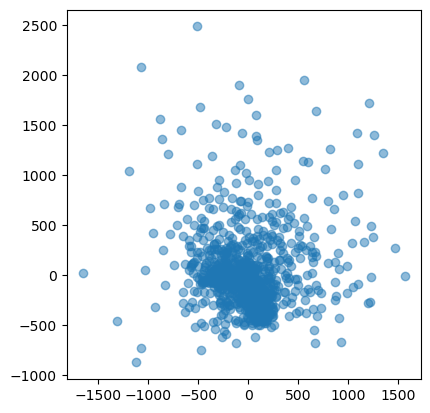

In [17]:
n_components = 2 # select number of components
mds = MDS(n_components=n_components, # initialize MDS
          dissimilarity="precomputed", # we have precomputed the distance matrix
          normalized_stress='auto',
          random_state=5 # select random state for reproducibility
         )
X = dist_arr # select distance array to analyze
MDS_scores = mds.fit_transform(X) # get MDS scores

plt.scatter(MDS_scores[:,0], MDS_scores[:,1], alpha=0.5) # plot
plt.gca().set_aspect("equal")


# Plot MDS with aspect ratio and solidity

In [18]:
# put MDS scores in rand_df for plotting

rand_df["MDS1"] = MDS_scores[:,0]
rand_df["MDS2"] = MDS_scores[:,1]

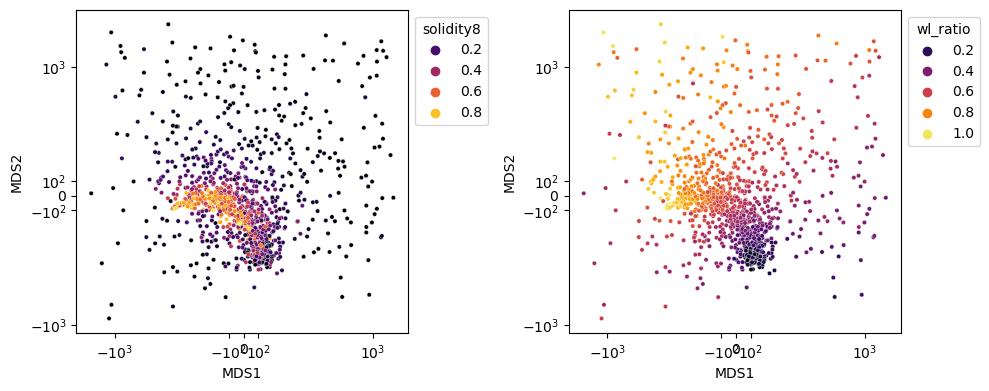

In [19]:
lt = 800

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
ax=sns.scatterplot(data=rand_df,x="MDS1",y="MDS2",s=10,hue="solidity8", palette="inferno")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.gca().set_aspect("equal")
plt.xscale('symlog',linthresh=lt)
plt.yscale('symlog',linthresh=lt)

plt.subplot(1,2,2)
ax=sns.scatterplot(data=rand_df,x="MDS1",y="MDS2",s=10,hue="wl_ratio", palette="inferno")
plt.gca().set_aspect("equal")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xscale('symlog',linthresh=lt)
plt.yscale('symlog',linthresh=lt)

plt.tight_layout()

/var/folders/74/p7lyl9yx35b6wh5_7x3ply4r0000gq/T/ipykernel_19664/75055603.py:1: UserWarning: The palette list has more values (14) than needed (5), which may not be intended.
  ax = sns.scatterplot(data=rand_df,


Text(0.5, 1.0, 'MDS of ECT\nby Major Clade')

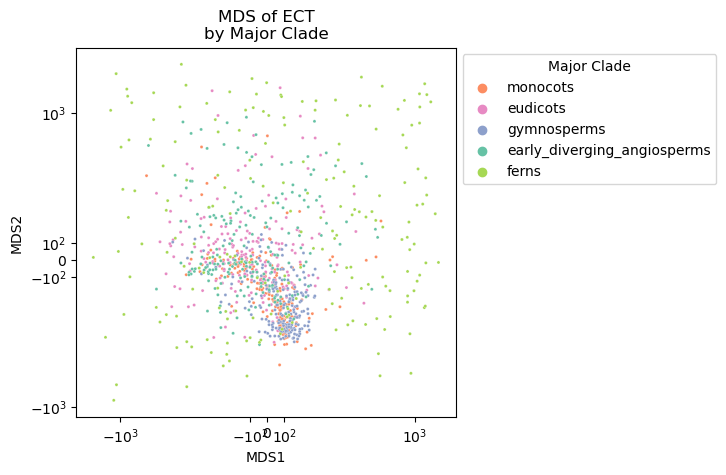

In [20]:
ax = sns.scatterplot(data=rand_df,
                x="MDS1",
                y="MDS2",
                s=5,
                hue="Major Clade", 
                palette=sns.color_palette(palette, 14))
plt.gca().set_aspect("equal")
plt.xscale('symlog',linthresh=lt)
plt.yscale('symlog',linthresh=lt)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title("MDS of ECT\nby Major Clade")

Plot MDS plot with random leaf outlines

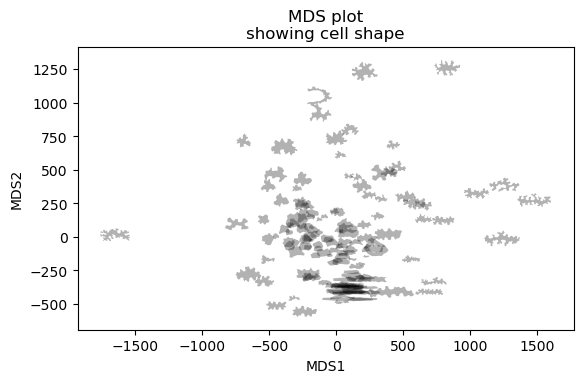

In [21]:
rand_num = 150 # set number of random cells to visualize
scale = 0.5 # set scale of cells
rand_state = 42 # set the random state

rand_plot_df = rand_df.sample(n=rand_num, random_state=rand_state) # select random cells

for i in range(len(rand_plot_df)): # for each of the randomly selected cells
    
    curr_file = "./npy_files/"+rand_plot_df["Sample_Number"].iloc[i]+".npy" # get current file
    curr_cell = np.load(curr_file) # load cell
    pca = PCA(n_components=2) # initiate PCA
    pca.fit_transform(curr_cell) # fit PCA to cell data to find longest axis
    pca_scores = pca.transform(curr_cell) # retrieve PCA scores of cell
    
    curr_cellx = pca_scores[:,0]*scale+rand_plot_df["MDS1"].iloc[i]
    curr_celly = pca_scores[:,1]*scale+rand_plot_df["MDS2"].iloc[i]
    
    plt.fill(curr_cellx, curr_celly, lw=0, c="k", alpha=0.3)
    plt.gca().set_aspect("equal")
    plt.xlabel("MDS1")
    plt.ylabel("MDS2")
    plt.title("MDS plot\nshowing cell shape")

__________

_______

____________

# From the [tutorial](https://github.com/MunchLab/ECT-Leaf-CNN/blob/main/leaf-example-tutorial/Tutorial-ECT_for_example_dataset.ipynb) on leaf shape classification by Sarah McGuire

# Classification by Major Clade

## Create the following folder structure:

Within the pwd, a folder for the ect analysis and sub-folders for outline inputs and ect outputs.

```
+--cell_ect_analysis
|    +--outline_input
|    +--ect_output
```

## Additionally, add `dataloaders.py`, `models.py`, and `utils.py` scripts from the github [repository](https://github.com/MunchLab/ECT-Leaf-CNN/tree/main/leaf-example-tutorial)

## Within the `dataloaders.py` file, change the `image_path` in the `create_datasets()` function:
- from `'/example_data/ect_output/'`
- to `'/cell_ect_analysis/ect_output/'`

In [22]:
from ect import ECT, EmbeddedGraph

import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path

First, we need to save the ECT images we will be classifying as `.npy` files with sub-folders for each class.

In [23]:
mypath_output = 'cell_ect_analysis/outline_input/'

for i in range(len(rand_df)): # for each cell

    curr_file = "./npy_files/"+rand_df["Sample_Number"].iloc[i]+".npy" # get current file
    curr_group = rand_df["Major Clade"].iloc[i] # get current group
    
    curr_cell = np.load(curr_file) # load current cell

    output_filedir = mypath_output+curr_group+"/X"+str(i)+".npy" # create output path
    Path(os.path.dirname(output_filedir)).mkdir(parents=True, exist_ok=True) # make directory
    np.save(output_filedir, curr_cell) # save output

# Create and save ECT outputs

In [24]:
mypath = 'cell_ect_analysis/outline_input/'
mypath_output = 'cell_ect_analysis/ect_output/'


# loop through file system
classes=[]
class_count = 0
for path, subdirs, files in os.walk(mypath):
    classes.extend(subdirs)
    files = [f for f in files if not f[0] == '.']
    subdirs[:] = [d for d in subdirs if (d[0] != '.')]
    print('Computing ECT of files in ', path, '...')
    print("There are ",len(files), ' samples to load in this directory.')
    
    for name in files:
        input_filedir = os.path.join(path, name)
        leaf = np.load(input_filedir)
        
        # Define a graph object for the leaf
        G = EmbeddedGraph()

        # Use coordinates of the leaf outline points to add vertices (and embedding coordinates) to the graph object
        valuesX = leaf[:,0]
        valuesY = leaf[:,1]
        for i in range(np.shape(leaf)[0]):
            G.add_node(i,valuesX[i],valuesY[i])

        # Add edges to the graph according to the outline order
        for i in range(np.shape(leaf)[0]-1):
            G.add_edge(i, i+1)
            G.add_edge(0,np.shape(leaf)[0]-1)
        
        # initialize the ECT object using 32 directions and 48 thresholds
        myect = ECT(num_dirs = 32, num_thresh=48)

        # Set the bounding radius to be the global dataset bounding radius
        # TO DO: compute the dataset global radius within ect package
        #global_bound_radius = 2.9092515639765497
        #myect.set_bounding_radius(global_bound_radius)

        myect.calculateECT(G)

        # The saved ECT matrix
        M = myect.get_ECT()


        # save the ECT matrix as a numpy file
        output_filedir = os.path.join(mypath_output+ input_filedir[len(mypath):])
        Path(os.path.dirname(output_filedir)).mkdir(parents=True, exist_ok=True)
        np.save(output_filedir, M)
        
        
    print('Saving the ECT of directory in ', path, '...')

Computing ECT of files in  cell_ect_analysis/outline_input/ ...
There are  0  samples to load in this directory.
Saving the ECT of directory in  cell_ect_analysis/outline_input/ ...
Computing ECT of files in  cell_ect_analysis/outline_input/ferns ...
There are  200  samples to load in this directory.
Saving the ECT of directory in  cell_ect_analysis/outline_input/ferns ...
Computing ECT of files in  cell_ect_analysis/outline_input/eudicots ...
There are  200  samples to load in this directory.
Saving the ECT of directory in  cell_ect_analysis/outline_input/eudicots ...
Computing ECT of files in  cell_ect_analysis/outline_input/early_diverging_angiosperms ...
There are  200  samples to load in this directory.
Saving the ECT of directory in  cell_ect_analysis/outline_input/early_diverging_angiosperms ...
Computing ECT of files in  cell_ect_analysis/outline_input/gymnosperms ...
There are  200  samples to load in this directory.
Saving the ECT of directory in  cell_ect_analysis/outline_in

# Train a CNN model on the ECT images

In [25]:
import torch
import argparse
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm

In [26]:
from models import CNN

Remember, within the `dataloaders.py` file, change the `image_path` in the `create_datasets()` function:
- from `'/example_data/ect_output/'`
- to `'/cell_ect_analysis/ect_output/'`

In [27]:
from dataloaders import create_datasets, create_data_loaders
from utils import save_model, save_plots, save_cf, SaveBestModel

In [28]:
NUM_EPOCHS = 50 # number of epochs to train the network for; type=int
LEARNING_RATE = 1e-3 # learning rate for training; type=float

In [29]:
# device
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}\n")

Computation device: cpu



### Load in the dataset and split into training and test datasets

In [30]:
train_dataset, test_dataset = create_datasets()

train_loader, test_loader = create_data_loaders(train_dataset, test_dataset)

/Users/chitwoo9/Desktop/ECT/cells/cell_ect_analysis/ect_output/
['ferns', 'eudicots', 'early_diverging_angiosperms', 'gymnosperms', 'monocots']
num_classes= 5
ECT data; using only normalize, rotation transforms on training data


/Users/chitwoo9/Desktop/ECT/cells/dataloaders.py:48: RuntimeWarning: divide by zero encountered in scalar divide
  new_arr = ((arr - arr.min()) * (1/(arr.max() - arr.min()) * 255)).astype('uint8')
/Users/chitwoo9/Desktop/ECT/cells/dataloaders.py:48: RuntimeWarning: invalid value encountered in multiply
  new_arr = ((arr - arr.min()) * (1/(arr.max() - arr.min()) * 255)).astype('uint8')
/Users/chitwoo9/Desktop/ECT/cells/dataloaders.py:48: RuntimeWarning: invalid value encountered in cast
  new_arr = ((arr - arr.min()) * (1/(arr.max() - arr.min()) * 255)).astype('uint8')


In [31]:
trainimages, trainlabels = next(iter(train_loader))
print(f'The tensor shape of each batch in the training dataset is \n[batch_size, num_channels, num_directions, num_thresholds]: {trainimages.shape}')

The tensor shape of each batch in the training dataset is 
[batch_size, num_channels, num_directions, num_thresholds]: torch.Size([4, 1, 32, 48])


training images


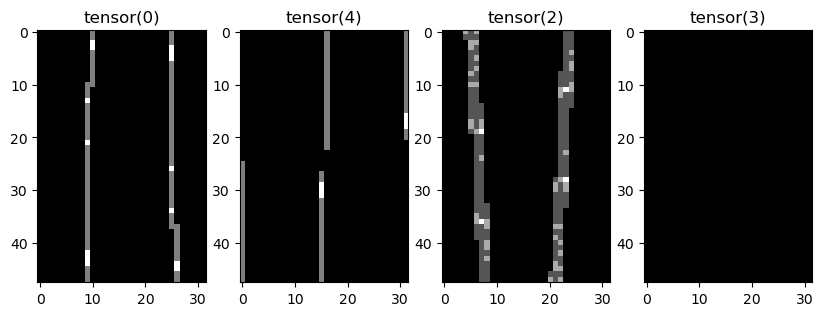

In [32]:
plt.style.use('default')
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
print('training images')
for i in range(4):
    ax = axes[i]
    ax.imshow(trainimages[i,0,:,:].T, cmap='gray')
    ax.set_title(trainlabels[i])
plt.show()

In [33]:
def train(model, train_loader, optimizer, lossfcn):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(train_loader), total=len(train_loader)):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # forward pass
        outputs = model(image)
        # calculate the loss
        loss = lossfcn(outputs, labels)
        train_running_loss += loss.item()
        # calculate the accuracy
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        # backpropagation
        loss.backward()
        # update the optimizer parameters
        optimizer.step()
    
    # loss and accuracy for the complete epoch
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(train_loader.dataset))
    return epoch_loss, epoch_acc

In [34]:
# function for validation
def validate(model, valid_loader, lossfcn):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        outputs_list = []
        labels_list = []
        for i, data in tqdm(enumerate(valid_loader), total=len(valid_loader)):
            counter += 1
            
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # forward pass
            outputs = model(image)
            outputs_list.append(outputs)
            labels_list.append(labels)
            # calculate the loss
            loss = lossfcn(outputs, labels)
            valid_running_loss += loss.item()
            # calculate the accuracy
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()
        
    # loss and accuracy for the complete epoch
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(valid_loader.dataset))

    return epoch_loss, epoch_acc

In [35]:
model = CNN(num_classes=train_dataset.num_classes, num_channels=trainimages.shape[1]).to(device)
print(model)

CNN(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=1920, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=5, bias=True)
)


In [36]:
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.\n")

1,974,149 total parameters.
1,974,149 training parameters.



In [37]:
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-3)
# loss function
lossfcn = nn.CrossEntropyLoss()
# initialize SaveBestModel class
save_best_model = SaveBestModel()

In [38]:
train_loss, valid_loss = [],[]
train_acc, valid_acc = [],[]

# begin training
for epoch in range(1,NUM_EPOCHS+1):
    print(f"[INFO]: Epoch {epoch} of {NUM_EPOCHS}")
    train_epoch_loss, train_epoch_acc = train(model, train_loader, optimizer, lossfcn)
    valid_epoch_loss, valid_epoch_acc = validate(model, test_loader, lossfcn)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")

    # save the best model up to current epoch, if we have the least loss in the current epoch
    save_best_model(
        valid_epoch_loss, epoch, model, optimizer, lossfcn
    )
    print('-'*50)
    

[INFO]: Epoch 1 of 50
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/50 [00:00<?, ?it/s]

Training loss: 1.531, training acc: 27.750
Validation loss: 1.363, validation acc: 39.500

Best validation loss: 1.3634811162948608

Saving best model for epoch: 1

--------------------------------------------------
[INFO]: Epoch 2 of 50
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/50 [00:00<?, ?it/s]

Training loss: 1.375, training acc: 36.125
Validation loss: 1.271, validation acc: 41.000

Best validation loss: 1.2712887692451478

Saving best model for epoch: 2

--------------------------------------------------
[INFO]: Epoch 3 of 50
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/50 [00:00<?, ?it/s]

Training loss: 1.346, training acc: 37.875
Validation loss: 1.289, validation acc: 32.500
--------------------------------------------------
[INFO]: Epoch 4 of 50
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/50 [00:00<?, ?it/s]

Training loss: 1.315, training acc: 37.500
Validation loss: 1.316, validation acc: 33.000
--------------------------------------------------
[INFO]: Epoch 5 of 50
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/50 [00:00<?, ?it/s]

Training loss: 1.285, training acc: 42.000
Validation loss: 1.277, validation acc: 43.500
--------------------------------------------------
[INFO]: Epoch 6 of 50
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/50 [00:00<?, ?it/s]

Training loss: 1.284, training acc: 42.625
Validation loss: 1.303, validation acc: 41.500
--------------------------------------------------
[INFO]: Epoch 7 of 50
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/50 [00:00<?, ?it/s]

Training loss: 1.272, training acc: 40.375
Validation loss: 1.265, validation acc: 38.000

Best validation loss: 1.264691789150238

Saving best model for epoch: 7

--------------------------------------------------
[INFO]: Epoch 8 of 50
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/50 [00:00<?, ?it/s]

Training loss: 1.266, training acc: 42.625
Validation loss: 1.234, validation acc: 44.000

Best validation loss: 1.2343182516098024

Saving best model for epoch: 8

--------------------------------------------------
[INFO]: Epoch 9 of 50
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/50 [00:00<?, ?it/s]

Training loss: 1.257, training acc: 42.125
Validation loss: 1.225, validation acc: 44.000

Best validation loss: 1.224673124551773

Saving best model for epoch: 9

--------------------------------------------------
[INFO]: Epoch 10 of 50
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/50 [00:00<?, ?it/s]

Training loss: 1.269, training acc: 42.125
Validation loss: 1.198, validation acc: 45.500

Best validation loss: 1.1981436121463775

Saving best model for epoch: 10

--------------------------------------------------
[INFO]: Epoch 11 of 50
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/50 [00:00<?, ?it/s]

Training loss: 1.245, training acc: 43.125
Validation loss: 1.236, validation acc: 42.500
--------------------------------------------------
[INFO]: Epoch 12 of 50
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/50 [00:00<?, ?it/s]

Training loss: 1.269, training acc: 43.750
Validation loss: 1.248, validation acc: 42.500
--------------------------------------------------
[INFO]: Epoch 13 of 50
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/50 [00:00<?, ?it/s]

Training loss: 1.267, training acc: 41.375
Validation loss: 1.234, validation acc: 40.500
--------------------------------------------------
[INFO]: Epoch 14 of 50
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/50 [00:00<?, ?it/s]

Training loss: 1.238, training acc: 44.375
Validation loss: 1.217, validation acc: 41.500
--------------------------------------------------
[INFO]: Epoch 15 of 50
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/50 [00:00<?, ?it/s]

Training loss: 1.230, training acc: 44.750
Validation loss: 1.192, validation acc: 41.500

Best validation loss: 1.1915238606929779

Saving best model for epoch: 15

--------------------------------------------------
[INFO]: Epoch 16 of 50
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/50 [00:00<?, ?it/s]

Training loss: 1.263, training acc: 44.000
Validation loss: 1.228, validation acc: 38.000
--------------------------------------------------
[INFO]: Epoch 17 of 50
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/50 [00:00<?, ?it/s]

Training loss: 1.231, training acc: 44.625
Validation loss: 1.218, validation acc: 44.500
--------------------------------------------------
[INFO]: Epoch 18 of 50
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/50 [00:00<?, ?it/s]

Training loss: 1.225, training acc: 43.000
Validation loss: 1.313, validation acc: 42.500
--------------------------------------------------
[INFO]: Epoch 19 of 50
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/50 [00:00<?, ?it/s]

Training loss: 1.258, training acc: 45.250
Validation loss: 1.209, validation acc: 45.500
--------------------------------------------------
[INFO]: Epoch 20 of 50
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/50 [00:00<?, ?it/s]

Training loss: 1.230, training acc: 42.500
Validation loss: 1.201, validation acc: 44.500
--------------------------------------------------
[INFO]: Epoch 21 of 50
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/50 [00:00<?, ?it/s]

Training loss: 1.221, training acc: 44.000
Validation loss: 1.182, validation acc: 47.500

Best validation loss: 1.182143861055374

Saving best model for epoch: 21

--------------------------------------------------
[INFO]: Epoch 22 of 50
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/50 [00:00<?, ?it/s]

Training loss: 1.211, training acc: 46.500
Validation loss: 1.214, validation acc: 41.500
--------------------------------------------------
[INFO]: Epoch 23 of 50
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/50 [00:00<?, ?it/s]

Training loss: 1.224, training acc: 44.125
Validation loss: 1.200, validation acc: 49.000
--------------------------------------------------
[INFO]: Epoch 24 of 50
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/50 [00:00<?, ?it/s]

Training loss: 1.210, training acc: 46.875
Validation loss: 1.198, validation acc: 42.000
--------------------------------------------------
[INFO]: Epoch 25 of 50
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/50 [00:00<?, ?it/s]

Training loss: 1.220, training acc: 45.625
Validation loss: 1.187, validation acc: 47.000
--------------------------------------------------
[INFO]: Epoch 26 of 50
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/50 [00:00<?, ?it/s]

Training loss: 1.191, training acc: 47.500
Validation loss: 1.218, validation acc: 41.000
--------------------------------------------------
[INFO]: Epoch 27 of 50
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/50 [00:00<?, ?it/s]

Training loss: 1.215, training acc: 46.375
Validation loss: 1.192, validation acc: 45.000
--------------------------------------------------
[INFO]: Epoch 28 of 50
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/50 [00:00<?, ?it/s]

Training loss: 1.194, training acc: 48.500
Validation loss: 1.171, validation acc: 48.000

Best validation loss: 1.1714604532718658

Saving best model for epoch: 28

--------------------------------------------------
[INFO]: Epoch 29 of 50
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/50 [00:00<?, ?it/s]

Training loss: 1.190, training acc: 48.500
Validation loss: 1.227, validation acc: 41.000
--------------------------------------------------
[INFO]: Epoch 30 of 50
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/50 [00:00<?, ?it/s]

Training loss: 1.192, training acc: 47.875
Validation loss: 1.210, validation acc: 48.000
--------------------------------------------------
[INFO]: Epoch 31 of 50
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/50 [00:00<?, ?it/s]

Training loss: 1.199, training acc: 47.375
Validation loss: 1.162, validation acc: 45.500

Best validation loss: 1.161920623779297

Saving best model for epoch: 31

--------------------------------------------------
[INFO]: Epoch 32 of 50
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/50 [00:00<?, ?it/s]

Training loss: 1.195, training acc: 49.875
Validation loss: 1.170, validation acc: 48.000
--------------------------------------------------
[INFO]: Epoch 33 of 50
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/50 [00:00<?, ?it/s]

Training loss: 1.180, training acc: 49.250
Validation loss: 1.160, validation acc: 50.000

Best validation loss: 1.1598357152938843

Saving best model for epoch: 33

--------------------------------------------------
[INFO]: Epoch 34 of 50
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/50 [00:00<?, ?it/s]

Training loss: 1.184, training acc: 49.125
Validation loss: 1.135, validation acc: 50.500

Best validation loss: 1.1346533572673798

Saving best model for epoch: 34

--------------------------------------------------
[INFO]: Epoch 35 of 50
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/50 [00:00<?, ?it/s]

Training loss: 1.175, training acc: 49.500
Validation loss: 1.142, validation acc: 50.500
--------------------------------------------------
[INFO]: Epoch 36 of 50
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/50 [00:00<?, ?it/s]

Training loss: 1.157, training acc: 49.250
Validation loss: 1.180, validation acc: 46.000
--------------------------------------------------
[INFO]: Epoch 37 of 50
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/50 [00:00<?, ?it/s]

Training loss: 1.155, training acc: 49.625
Validation loss: 1.131, validation acc: 49.500

Best validation loss: 1.1312617194652557

Saving best model for epoch: 37

--------------------------------------------------
[INFO]: Epoch 38 of 50
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/50 [00:00<?, ?it/s]

Training loss: 1.155, training acc: 48.250
Validation loss: 1.134, validation acc: 48.500
--------------------------------------------------
[INFO]: Epoch 39 of 50
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/50 [00:00<?, ?it/s]

Training loss: 1.163, training acc: 49.625
Validation loss: 1.123, validation acc: 45.000

Best validation loss: 1.1234341084957122

Saving best model for epoch: 39

--------------------------------------------------
[INFO]: Epoch 40 of 50
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/50 [00:00<?, ?it/s]

Training loss: 1.155, training acc: 52.625
Validation loss: 1.124, validation acc: 49.000
--------------------------------------------------
[INFO]: Epoch 41 of 50
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/50 [00:00<?, ?it/s]

Training loss: 1.142, training acc: 48.750
Validation loss: 1.105, validation acc: 51.500

Best validation loss: 1.1054554802179337

Saving best model for epoch: 41

--------------------------------------------------
[INFO]: Epoch 42 of 50
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/50 [00:00<?, ?it/s]

Training loss: 1.177, training acc: 49.250
Validation loss: 1.120, validation acc: 51.500
--------------------------------------------------
[INFO]: Epoch 43 of 50
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/50 [00:00<?, ?it/s]

Training loss: 1.136, training acc: 50.125
Validation loss: 1.121, validation acc: 51.000
--------------------------------------------------
[INFO]: Epoch 44 of 50
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/50 [00:00<?, ?it/s]

Training loss: 1.143, training acc: 52.500
Validation loss: 1.149, validation acc: 50.500
--------------------------------------------------
[INFO]: Epoch 45 of 50
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/50 [00:00<?, ?it/s]

Training loss: 1.138, training acc: 52.125
Validation loss: 1.111, validation acc: 49.500
--------------------------------------------------
[INFO]: Epoch 46 of 50
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/50 [00:00<?, ?it/s]

Training loss: 1.126, training acc: 50.625
Validation loss: 1.111, validation acc: 51.500
--------------------------------------------------
[INFO]: Epoch 47 of 50
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/50 [00:00<?, ?it/s]

Training loss: 1.140, training acc: 50.500
Validation loss: 1.131, validation acc: 52.500
--------------------------------------------------
[INFO]: Epoch 48 of 50
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/50 [00:00<?, ?it/s]

Training loss: 1.134, training acc: 50.750
Validation loss: 1.088, validation acc: 53.500

Best validation loss: 1.0883091336488724

Saving best model for epoch: 48

--------------------------------------------------
[INFO]: Epoch 49 of 50
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/50 [00:00<?, ?it/s]

Training loss: 1.132, training acc: 50.625
Validation loss: 1.088, validation acc: 51.000
--------------------------------------------------
[INFO]: Epoch 50 of 50
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/50 [00:00<?, ?it/s]

Training loss: 1.106, training acc: 52.750
Validation loss: 1.100, validation acc: 52.000
--------------------------------------------------


Saving final model...


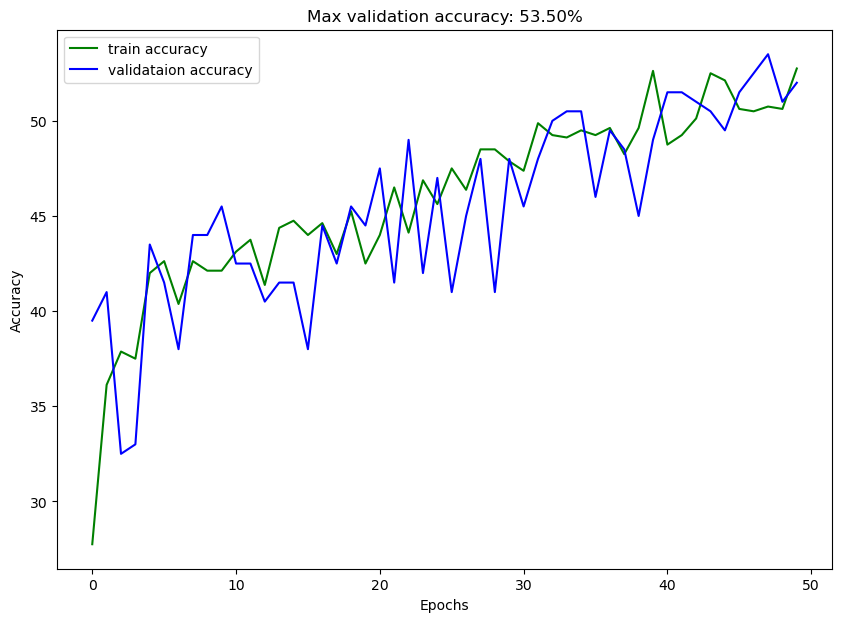

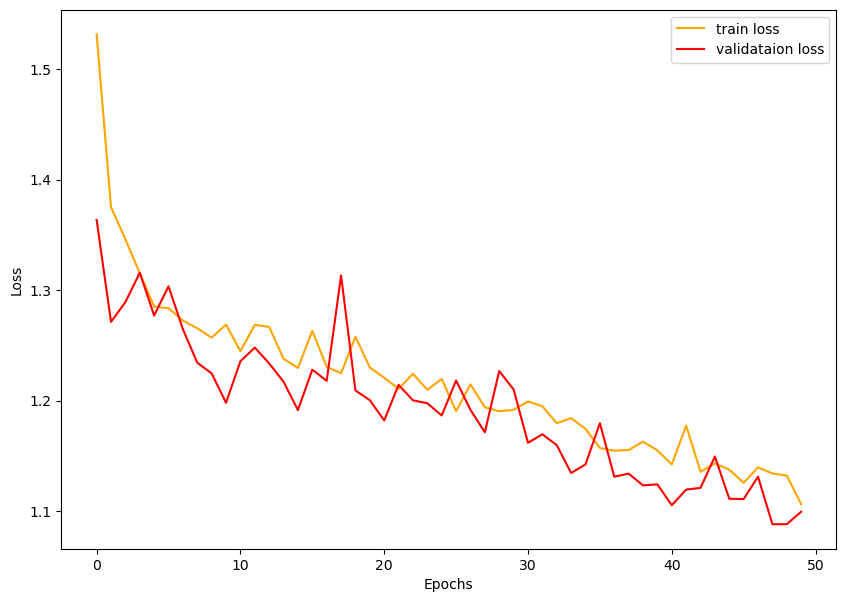

In [39]:
save_model(NUM_EPOCHS, model, optimizer, lossfcn)
save_plots(train_acc, valid_acc, train_loss, valid_loss)

Using validation to compute confusion matrix


/var/folders/74/p7lyl9yx35b6wh5_7x3ply4r0000gq/T/ipykernel_19664/207180029.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('outputs/best_model.pt

  0%|          | 0/50 [00:00<?, ?it/s]

classes: ['ferns', 'eudicots', 'early_diverging_angiosperms', 'gymnosperms', 'monocots']
Test Result:
Accuracy Score: 53.00%
_______________________________________________
CLASSIFICATION REPORT:
                   0          1          2          3          4  accuracy  \
precision   0.465116   0.743590   0.388889   0.482759   0.900000      0.53   
recall      0.833333   0.966667   0.333333   0.437500   0.187500      0.53   
f1-score    0.597015   0.840580   0.358974   0.459016   0.310345      0.53   
support    48.000000  30.000000  42.000000  32.000000  48.000000      0.53   

            macro avg  weighted avg  
precision    0.596071      0.598074  
recall       0.551667      0.530000  
f1-score     0.513186      0.492681  
support    200.000000    200.000000  
_______________________________________________
Confusion Matrix: 
 [[40  0  7  1  0]
 [ 0 29  0  0  1]
 [25  0 14  3  0]
 [13  0  5 14  0]
 [ 8 10 10 11  9]]



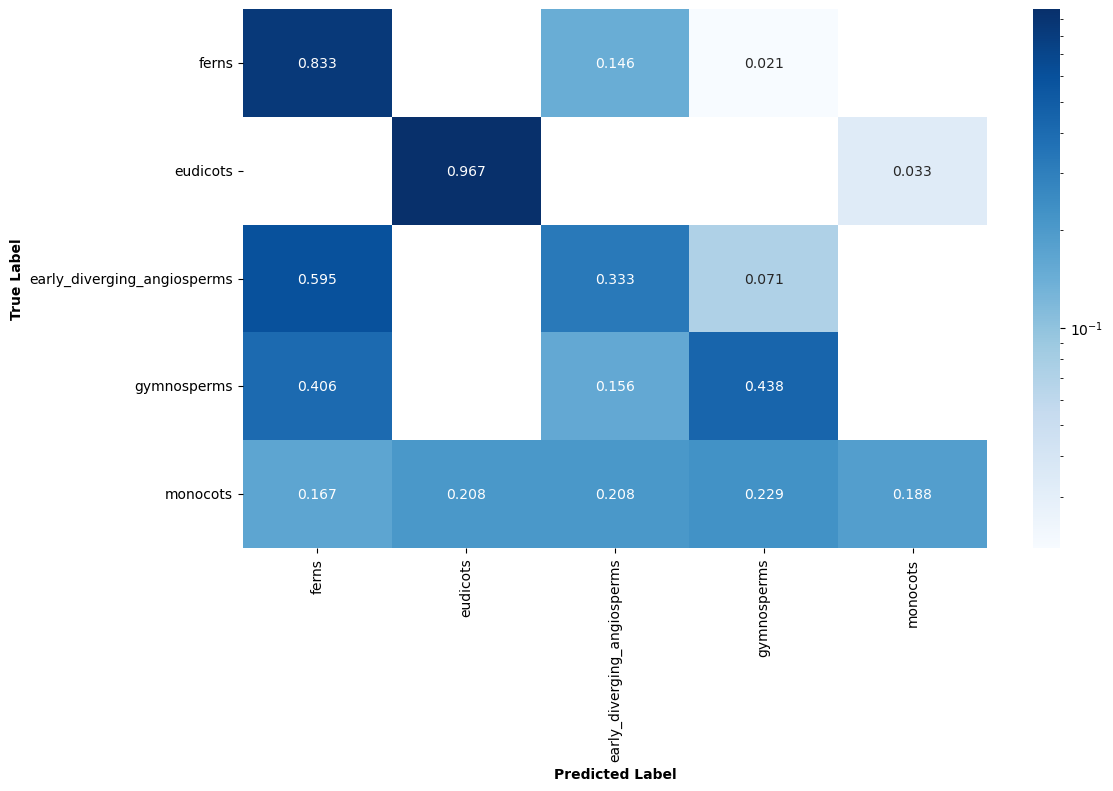

In [40]:
# model, valid_loader, lossfcn
model = CNN(num_classes=train_dataset.num_classes, num_channels=trainimages.shape[1])

state_dict = torch.load('outputs/best_model.pth')['model_state_dict']
model.load_state_dict(state_dict)
model.eval()
print('Using validation to compute confusion matrix')
valid_running_pred = []
valid_running_labels = []
counter = 0
with torch.no_grad():
    for i, data in tqdm(enumerate(test_loader), total=len(test_loader)):
        counter += 1
        
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        # forward pass
        outputs = model(image)
        # calculate the accuracy
        _, preds = torch.max(outputs.data, 1)

        valid_running_pred.append(preds)
        valid_running_labels.append(labels)
    
# confusion matrix for the complete epoch
valid_running_pred = torch.cat(valid_running_pred)
valid_running_labels = torch.cat(valid_running_labels)
print('classes:',test_dataset.classes)
save_cf(valid_running_pred,valid_running_labels, test_dataset.classes)

____________

____________

____________

In [296]:
def ect_diff_pca(ect1, ect2, dir_num):
    """
    inputs: two, 2D arrays of ECTs and number of directional axes
    output: the minimum sum diff between the two ECT arrays across different orientations
    """
    flip_ect1 = np.flip(ect1, axis=0) # flip ECT axes
    trans_ect1 = np.roll(ect1, int(dir_num/2), axis=0) # translate ECT axes
    ft_ect1 = np.roll(flip_ect1, int(dir_num/2), axis=0) # translate ECT axes

    diff_orig = np.sum(np.abs(ect2 - ect1)) # difference between ECT and original
    diff_flip = np.sum(np.abs(ect2 - flip_ect1)) # difference between ECT and flipped
    diff_trans = np.sum(np.abs(ect2 - trans_ect1)) # difference between ECT and translated
    diff_ft = np.sum(np.abs(ect2 - ft_ect1)) # difference between ECT and flipped translated

    return np.min([diff_orig,diff_flip,diff_trans,diff_ft])

In [297]:
# create a 2D array to hold the distance matrix
# number of ECTs x number of ECTs
dist_arr = np.zeros((np.shape(ect_arr)[0],np.shape(ect_arr)[0]))

for i in range(np.shape(ect_arr)[0]): # for each ECT
    if i%100==0: # print if divisible by 100
        print(i)
    ect1 = ect_arr[i] # get first ECT
    for j in range(np.shape(ect_arr)[0]): # for each ECT
        ect2 = ect_arr[j] # get second ECT
        dist_arr[i,j] = ect_diff_pca(ect1, ect2, dir_num=num_dir) # get difference between ECTs

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300


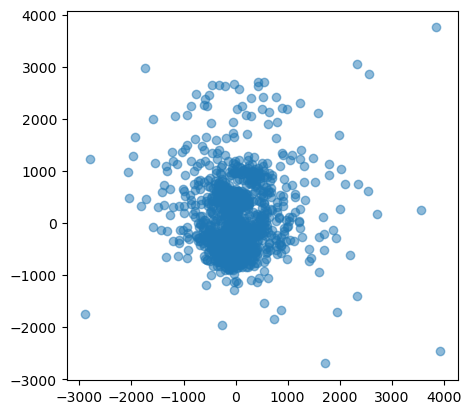

In [298]:
n_components = 2 # select number of components
mds = MDS(n_components=n_components, # initialize MDS
          dissimilarity="precomputed", # we have precomputed the distance matrix
          normalized_stress='auto',
          random_state=5 # select random state for reproducibility
         )
X = dist_arr # select distance array to analyze
MDS_scores = mds.fit_transform(X) # get MDS scores

plt.scatter(MDS_scores[:,0], MDS_scores[:,1], alpha=0.5) # plot
plt.gca().set_aspect("equal")


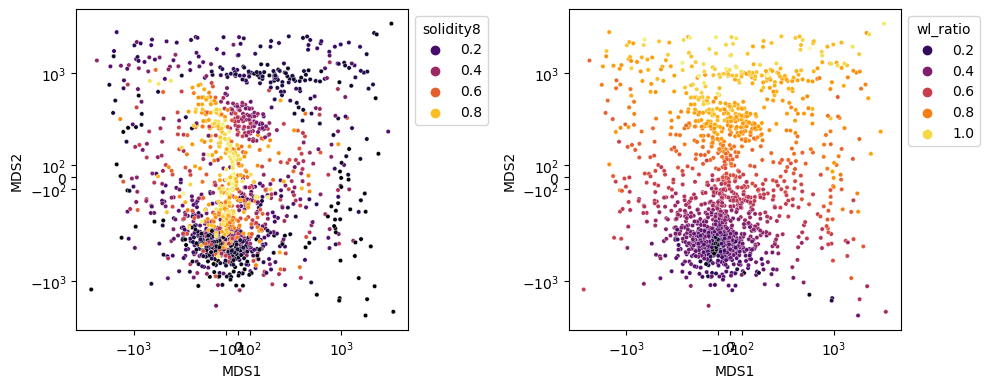

In [299]:
lt = 800

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
ax=sns.scatterplot(data=rand_df,x="MDS1",y="MDS2",s=10,hue="solidity8", palette="inferno")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.gca().set_aspect("equal")
plt.xscale('symlog',linthresh=lt)
plt.yscale('symlog',linthresh=lt)

plt.subplot(1,2,2)
ax=sns.scatterplot(data=rand_df,x="MDS1",y="MDS2",s=10,hue="wl_ratio", palette="inferno")
plt.gca().set_aspect("equal")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xscale('symlog',linthresh=lt)
plt.yscale('symlog',linthresh=lt)

plt.tight_layout()

Text(0.5, 1.0, 'MDS of ECT\nby group')

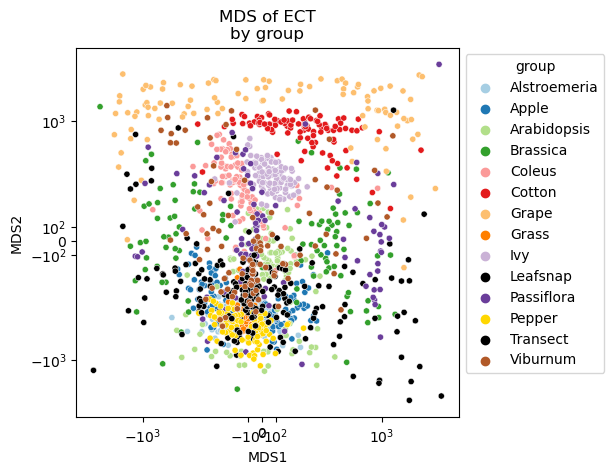

In [300]:
ax = sns.scatterplot(data=rand_df,
                x="MDS1",
                y="MDS2",
                s=20,
                hue="group", 
                palette=sns.color_palette(palette, 14))
plt.gca().set_aspect("equal")
plt.xscale('symlog',linthresh=lt)
plt.yscale('symlog',linthresh=lt)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title("MDS of ECT\nby group")